<h1><center>Practice of Large Scale Machine Learning - TP Avazu<center></h1>
<h2><center>2020<center></h2>

In [20]:
import sys
from zipfile import ZipFile
import os.path as op
try:
    from urllib.request import urlretrieve
except ImportError:  # Python 2 compat
    from urllib import urlretrieve
    
AVAZU_URL = "https://bianchi.wp.imt.fr/files/2019/05/train-1000000.zip"
AVAZU_FILENAME = AVAZU_URL.rsplit('/', 1)[1]


if not op.exists(AVAZU_FILENAME):
    print('Downloading %s to %s...' % (AVAZU_URL, AVAZU_FILENAME))
    urlretrieve(AVAZU_URL, AVAZU_FILENAME)
    print('Extracting to %s...' % AVAZU_FILENAME)
    ZipFile(AVAZU_FILENAME).extractall('.')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
%matplotlib inline

# Les données
La signification des features est fournie ici https://www.kaggle.com/c/avazu-ctr-prediction/data  
<font color="red">
Charger les données dans une dataframe et visualiser les premières lignes.</font>

In [21]:
df = pd.read_csv('train-1000000')

In [22]:
df.head(10)

,id,click,hour,C1,banner_pos,site_id,site_domain,site_category,app_id,app_domain,app_category,device_id,device_ip,device_model,device_type,device_conn_type,C14,C15,C16,C17,C18,C19,C20,C21
0,3.983206e+18,0,14102915,1005,1,e151e245,7e091613,f028772b,ecad2386,7801e8d9,07d7df22,a99f214a,fb6566d3,be87996b,1,2,4687,320,50,423,2,39,100148,32
1,7.756884e+18,0,14103007,1002,0,cb809abf,74acf31a,50e219e0,ecad2386,7801e8d9,07d7df22,9b7af851,ac5a4a77,7e6190f3,0,0,17894,320,50,2039,2,39,100077,32
2,6.941774e+17,0,14102711,1005,0,85f751fd,c4e18dd6,50e219e0,e9739828,df32afa9,cef3e649,a99f214a,748e298a,3c55fad5,1,0,22684,320,50,2619,1,163,100055,71
3,2.664154e+18,1,14102903,1005,0,85f751fd,c4e18dd6,50e219e0,a5184c22,b8d325c3,0f2161f8,a99f214a,a50da3d4,c5cc73c1,1,0,23222,320,50,2676,0,35,100176,221
4,1.480510e+19,0,14102902,1005,1,791b5571,fd13bc73,f028772b,ecad2386,7801e8d9,07d7df22,a99f214a,d5f88679,a5bce124,1,0,8330,320,50,761,3,175,100081,23
5,1.591127e+19,0,14102700,1005,0,85f751fd,c4e18dd6,50e219e0,febd1138,82e27996,0f2161f8,a99f214a,189590f9,2ea4f8ba,1,0,21611,320,50,2480,3,297,100111,61
6,4.149473e+18,0,14102408,1010,1,85f751fd,c4e18dd6,50e219e0,03a08c3f,7801e8d9,0f2161f8,192d98b0,74169322,c144e605,4,3,15704,320,50,1722,0,35,100084,79
7,1.085379e+19,0,14102904,1005,0,85f751fd,c4e18dd6,50e219e0,a5184c22,b8d325c3,0f2161f8,a99f214a,342b6e9e,a0f5f879,1,0,23224,320,50,2676,0,35,100176,221
8,2.629918e+18,0,14102513,1010,1,85f751fd,c4e18dd6,50e219e0,8486dd4e,7801e8d9,0f2161f8,50dc7a55,2064d2cc,d6cd23ab,4,0,17875,320,50,2036,3,47,-1,156
9,1.419062e+19,0,14102600,1010,1,85f751fd,c4e18dd6,50e219e0,04f2be5f,7801e8d9,0f2161f8,feb99a64,72c47474,a0f5f879,4,3,22552,320,50,2602,0,163,100084,182


In [23]:
df.columns

Index(['id', 'click', 'hour', 'C1', 'banner_pos', 'site_id', 'site_domain',
       'site_category', 'app_id', 'app_domain', 'app_category', 'device_id',
       'device_ip', 'device_model', 'device_type', 'device_conn_type', 'C14',
       'C15', 'C16', 'C17', 'C18', 'C19', 'C20', 'C21'],
      dtype='object')

<font color="red">
Quelle est la fréquence des 'clicks' dans la base de donnée ? </font>

In [24]:
df['click'].mean()

0.169971

On est donc en présence d'un jeu de données déséquilibré. La classe des 'clics' constitue moins d'un cinquième de toute la base de données. On sait d'emblée qu'un classifieur prédisant toujours 'non-clic' aura d'assez bonnes performances en termes de taux d'erreur (de l'ordre de 0.17). La courbe ROC ou le lift seront de meilleures métriques de performance.
<p>
<font color="red">
Quelles sont les features catégorielles ? Avec la méthode df.nunique(), calculer combien de valeurs distinctes elles prennent chacune</font>

In [25]:
df.nunique()

id                  1000000
click                     2
hour                    240
C1                        7
banner_pos                7
site_id                2651
site_domain            2871
site_category            22
app_id                 3157
app_domain              198
app_category             26
device_id            150501
device_ip            555248
device_model           5168
device_type               5
device_conn_type          4
C14                    2243
C15                       8
C16                       9
C17                     420
C18                       4
C19                      66
C20                     163
C21                      60
dtype: int64

<font color="red">
    Si on devait procéder à un encodage en dummies de toutes les variables catégorielles, quelle serait la dimension du modèle ?
    <br><br>
    In other words: what would be the dimension of our big feature vector encoded with dummies. 
    <br>
    Hint: if you have just 3 categories A, B and C, you would have a vector of dimension 3 (or 2 if you use drop_first=True).
</font>

In [26]:
df.nunique().values[2:].sum() # We just sum the number of unique values for each variable

723078

<font color="red">
Analyser la colonne 'hour' : quel est le format utilisé ? Comment peut on transformer/simplifier cette feature ?</font>

In [27]:
print(df['hour'].head())
print(df['hour'].tail())
# We notice that:
# - the first 2 digits correspond to the year (e.g. "14" corresponds to 2014). Always constant
# - the next 2 digits correspond to the month (e.g. "10" corresponds to October). Always constant
# - the next 2 digits correspond to the day (e.g. "29" corresponds to 29th)
# - the last 2 digits correspond to the hour (e.g. "15" corresponds to 3pm)

0    14102915
1    14103007
2    14102711
3    14102903
4    14102902
Name: hour, dtype: int64
999995    14102602
999996    14102101
999997    14102318
999998    14102908
999999    14102600
Name: hour, dtype: int64


<font color="red">
Tester le script suivant.</font>

In [28]:
import datetime
def datesplit(originalDate):
    originalDate = str(originalDate)
    
    year = int("20" + originalDate[0:2])
    month = int(originalDate[2:4])
    day = int(originalDate[4:6])
    hour = int(originalDate[6:8])
    
    return datetime.datetime(year, month, day, hour)

# Exemple :
datesplit(14102915).weekday(), datesplit(14102915).hour

(2, 15)

<font color="red">
Avec la méthode "apply", créer une colonne 'weekday' pour le jour de la semaine, et remplacer la colonne 'hour' par l'heure.
</font>

In [29]:
df['weekday'] = df['hour'].apply(lambda x:datesplit(x).weekday())
df['hour'] = df['hour'].apply(lambda x:datesplit(x).hour)

<font color="red">
Avec la méthode "groupby", visualiser l'influence de l'heure et du jour sur les clicks (on pourra tracer la courbe clic en fonction de l'heure).</font>

In [30]:
df.groupby('weekday').mean()['click']

weekday
0    0.183143
1    0.161577
2    0.158675
3    0.173795
4    0.173392
5    0.183995
6    0.183105
Name: click, dtype: float64

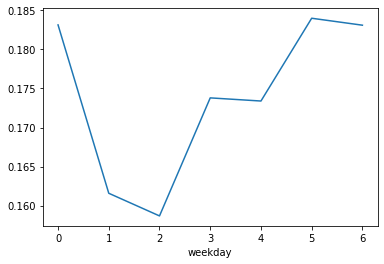

In [31]:
df.groupby('weekday').mean()['click'].plot()

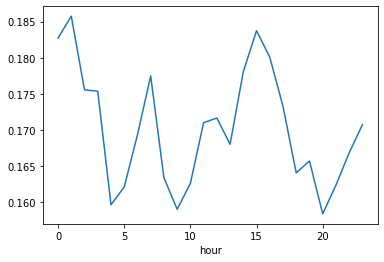

In [32]:
df.groupby('hour').mean()['click'].plot()

### Premier travail sur un modèle restreint
Commencer par comprendre les features ayant peu de modalités : 
'hour', 'weekday', 'C1', 'banner_pos', 'site_category', 'app_category', 'device_type', 'device_conn_type', 'C15', 'C16', 'C18', 'C21'.

<font color="red">
    Inspecter par exemple les colonnes 'C15' (dimension de l'annonce) et 'site_category' : visualiser la moyenne des clics.
    <br><br>
    You can for instance apply the method ".value_counts()" to the columns of your interest.
    For the mean of the click, don't forget to use "df.groupby("Variable_of_interest")" and then select the colunm for which you want the mean.
</font>

In [33]:
df.groupby('C15').mean()['click']

C15
120     0.033708
216     0.129612
300     0.360537
320     0.158767
480     0.285714
728     0.054144
768     0.375000
1024    0.166667
Name: click, dtype: float64

In [34]:
df.groupby('site_category').mean()['click']
# df.groupby('site_category')['click'].mean().sort_values(ascending=False) # column selection then mean

site_category
0569f928    0.053613
28905ebd    0.208076
335d28a8    0.089824
3e814130    0.284245
42a36e14    0.225806
50e219e0    0.128597
5378d028    0.000000
70fb0e29    0.144737
72722551    0.059172
75fa27f6    0.111305
76b2941d    0.035756
8fd0aea4    0.015873
9ccfa2ea    0.000000
a818d37a    0.000000
bcf865d9    0.000000
c0dd3be3    0.128655
c706e647    0.000000
da34532e    0.000000
dedf689d    0.530449
e787de0e    0.000000
f028772b    0.179719
f66779e6    0.034564
Name: click, dtype: float64

<font color="red">
    Certaines catégories de site ont un taux de click nul. Pourquoi ? Vérifier en affichant le count de chaque modalité.

    <br><br>
    Hint: you can use the method "value_counts()"
</font>

In [35]:
# for counting how many example of each class you have
# df['C15'].value_counts()
df['site_category'].value_counts()

50e219e0    408921
f028772b    313339
28905ebd    182020
3e814130     75667
f66779e6      6365
75fa27f6      4007
335d28a8      3351
76b2941d      2573
c0dd3be3      1026
72722551       676
dedf689d       624
70fb0e29       608
0569f928       429
8fd0aea4       189
a818d37a        81
42a36e14        62
e787de0e        28
bcf865d9        16
5378d028        11
9ccfa2ea         5
da34532e         1
c706e647         1
Name: site_category, dtype: int64

Il est pratique visualiser les deux colonnes conjointement :

<font color="red">
Diviser le jeu de données en un train et un test set (test_size = 0.1, random_state = 100)</font>

In [37]:
from sklearn.model_selection import train_test_split
Xtrain, Xtest, ytrain, ytest = train_test_split(df.drop(['click'], axis=1),df['click'],test_size = 0.1,random_state = 100)

In [38]:
Xtrain.head()

,id,hour,C1,banner_pos,site_id,site_domain,site_category,app_id,app_domain,app_category,device_id,device_ip,device_model,device_type,device_conn_type,C14,C15,C16,C17,C18,C19,C20,C21,weekday
92438,3.406845e+18,10,1010,1,85f751fd,c4e18dd6,50e219e0,495d447f,7801e8d9,0f2161f8,86aeec5e,96462a59,f07e20f8,4,3,15703,320,50,1722,0,35,-1,79,0
60898,1.598544e+19,22,1005,0,85f751fd,c4e18dd6,50e219e0,8bcb1385,2347f47a,fc6fa53d,17808071,1cf29716,5db079b5,1,2,15703,320,50,1722,0,35,-1,79,1
556199,1.792626e+19,4,1005,0,12fb4121,6b59f079,f028772b,ecad2386,7801e8d9,07d7df22,a99f214a,a12e9c26,1c6a881d,1,2,22553,320,50,2602,0,163,-1,182,0
193129,8.452958e+18,12,1005,1,856e6d3f,58a89a43,f028772b,ecad2386,7801e8d9,07d7df22,a99f214a,c9cff219,68b6db2c,1,0,19772,320,50,2227,0,935,100075,48,1
231985,1.640144e+19,13,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,07d7df22,a99f214a,92c5ab4e,3bd9e8e7,1,0,15708,320,50,1722,0,35,100084,79,6


# Premier travail sur un nombre réduit de features
<p>
<font color="red">
Dans une nouvelle dataframe X1, extraire les colonnes : 'hour', 'weekday', 'C1', 'banner_pos', 'site_category', 'app_category', 'device_type', 'device_conn_type', 'C15', 'C16', 'C18', 'C21'.
</font>

In [51]:
some_columns = ['hour', 'weekday', 'C1', 'banner_pos', 'site_category', 
                'app_category', 'device_type', 'device_conn_type', 'C15', 'C16', 'C18', 'C21']

<font color="red"> - Importer CategoricalEncoder de sklearn.preprocessing.  
- Fitter le CategoricalEncoder sur les données de train restreintes aux colonnes ci-dessus.  
- Transformer les données de train et de test en dummies.
</font>

In [52]:
# from sklearn.preprocessing import CategoricalEncoder
# ce = CategoricalEncoder()
# Xtrain_oh = ce.fit_transform(Xtrain[some_columns]) # fit_transform de Xtrain restreint aux colonnes sélectionnées
# Xtest_oh = ce.transform(Xtest[some_columns])

In [53]:
from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder()
Xtrain_oh = ohe.fit_transform(Xtrain[some_columns])
Xtest_oh = ohe.transform(Xtest[some_columns])

<font color="red">
Quel est désormais le nombre de features ?</font>

In [54]:
print(Xtrain.shape)
print(Xtrain_oh.shape)
# 183 features instead of 24

(900000, 24)
(900000, 183)


<font color="red">
Visualiser la première ligne de la matrice de design obtenue (la convertir en numpy.array avec la méthode .toarray())</font>

In [55]:
Xtrain_oh.toarray()[0,:] # pb here, not same dummies

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

<font color="red">
Fitter un modèle de régression logistique aux données d'apprentissage.
<br>
Give a value to C
</font>

In [56]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(C=1.0,solver='lbfgs')
lr.fit(Xtrain_oh, ytrain)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

<font color="red">
Avec predict et predict_proba, afficher les décisions dures et les décisions douces obtenues sur les données de test.
<br>
Soft decision is nothing but the probability of predicting 1
</font>

In [57]:
hard = lr.predict(Xtest_oh)
soft = lr.predict_proba(Xtest_oh)[:,1]

<font color="red">
    Evaluer la probabilité d'erreur et commenter.
    <br>
    Use the '.predict' method of your model and get the error using the 'accuracy_score' function of sklearn.metrics
</font>

In [58]:
from sklearn.metrics import accuracy_score
ypred = lr.predict(Xtest_oh)
accuracy_score(ytest, ypred)

0.83043

<font color="red">
Afficher la courbe ROC et l'aire sous la courbe ROC.</font>

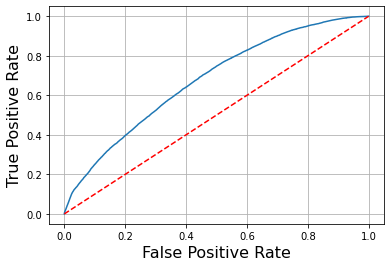

In [59]:
from sklearn.metrics import roc_curve
pfa, power, _ = roc_curve(ytest, soft)
plt.plot(pfa, power)
plt.grid()
plt.plot([0, 1], [0, 1], 'r--')
plt.xlabel('False Positive Rate', fontsize=16);
plt.ylabel('True Positive Rate', fontsize=16);

In [60]:
from sklearn.metrics import roc_auc_score, log_loss
log_loss(ytest, soft), roc_auc_score(ytest, soft)

(0.42516095399081655, 0.6762410005458575)

<font color="red">
Importer la fonction plot_lift de utils.py, et afficher la courbe de lift.  
Quel est le lift du premier quart de la population identifié par le test ?</font>

In [61]:
def plotlift(y_true,soft_pred):
    df = pd.DataFrame(np.array([y_true,soft_pred]).T,columns=['true','soft'])
    df.sort_values(by='soft',ascending=False,inplace=True)
    lift = pd.concat([df.groupby('soft').count(),df.groupby('soft').sum()],axis=1)
    lift.sort_index(ascending=False,inplace=True)
    lift.columns = ['strate size','positive']
    lift['negative'] = lift['strate size'] - lift['positive']
    n_positive = df['true'].sum()
    n_negative = df['true'].count()-n_positive
    lift.index.name = 'threshold'
    lift['Group size'] = lift['strate size'].cumsum()
    lift['Group hit probability'] = lift['positive'].cumsum() / lift['Group size']
    lft = lift['Group hit probability'].values / (n_positive /(n_positive+n_negative))
    gr = lift['Group size'].values / len(y_true)
    plt.plot(gr,lft)
    mx = np.max(lft * (gr >= 0.1))
    plt.xlim((0.1, 1))
    plt.ylim((0,1.3*mx))
    plt.grid()
    return 

[]

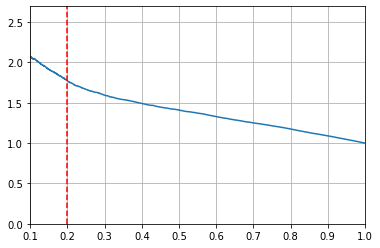

In [62]:
plotlift(ytest, soft)
plt.axvline(x=0.2, linestyle='--', color='r')
plt.plot()

On obtient un lift égal à un peu moins de deux pour environ 20% de la population (~1.75). C'est à dire qu'on a identifié un segment de la population pour lequel la probabilité de clic est (environ) deux fois supérieure à la population globale.

# Modèle complet
On considère l'exemple de la colonne 'site_id'
<br>
<font color="red">
- Calculer pour chaque modalité, le nombre d'occurrence dans la base de données et la moyenne des clics pour cette modalité.  
- Avec sns.jointplot, représenter l'ensemble des points (count,mean) de chaque modalité.</font>


In [63]:
import seaborn as sns

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


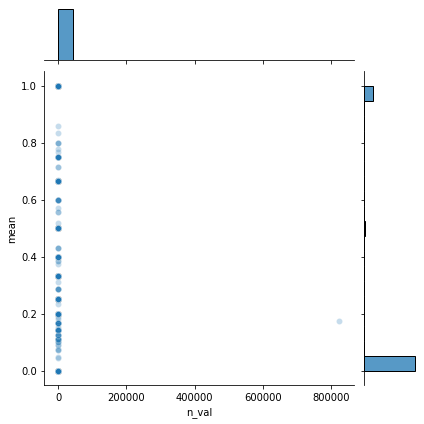

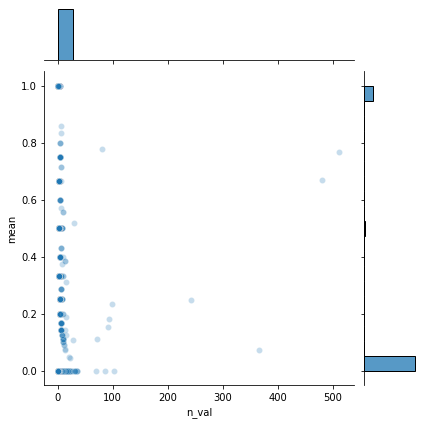

In [64]:
col = 'device_id'
a = pd.DataFrame([df.groupby(col).mean()['click'], df.groupby(col).count()['click']]).transpose()
a.columns = ['mean', 'n_val']
sns.jointplot(a['n_val'], a['mean'], alpha=0.25);
thres = 10000
sns.jointplot(a[a['n_val']<thres]['n_val'],a[a['n_val']<thres]['mean'],alpha=0.25);

<font color="red">A quoi sert le paramètre alpha dans les commandes ci-dessus ?</font>

Plusieurs sites ayant de fortes occurrences dans la base de donnée ont des fréquences de clics très différentes de la moyenne. Il est pertinent de conserver de la colonne 'site_id' au moins les modalités ayant le plus de count.  

<font color="red">
Effectuer le même travail avec la colonne 'device_id'. Que remarquez vous ? A quoi pourrait correspondre le point isolé ?</font>

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


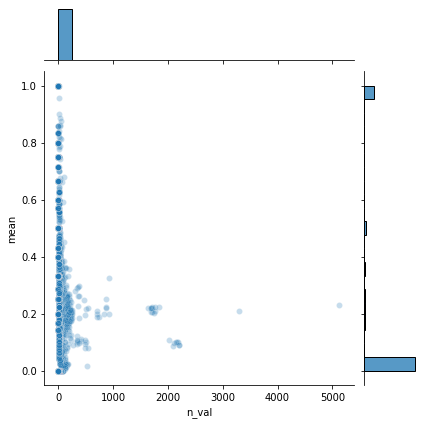

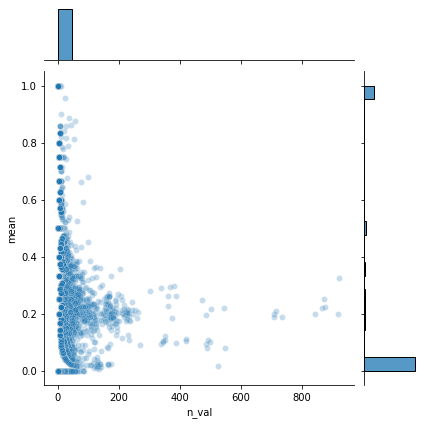

In [65]:
col = 'device_ip'
a = pd.DataFrame([df.groupby(col).mean()['click'], df.groupby(col).count()['click']]).transpose()
a.columns = ['mean', 'n_val']
thres = 1000


sns.jointplot(a['n_val'], a['mean'], alpha=0.25);
sns.jointplot(a[a['n_val']<thres]['n_val'], a[a['n_val']<thres]['mean'], alpha=0.25);

<font color="red">
Dans la colonne df['device_id'], repérer la valeur V correspondant au plus grand nombre count. Use '.value_counts()'. Créer une nouvelle colonne df['user'] définie de la manière suivante :</font>
$$
\text{user} = \left\{\begin{array}[h]{ll} \text{device_ip + device_model} & \text{si device_id = V}\\ \text{device_id} & \text{sinon.}\end{array}\right.
$$
Add some help here

In [66]:
V = df['device_id'].value_counts().index[0]
df['user'] = (df['device_ip'] + df['device_model']) * (df['device_id']==V) + df['device_id'] * (df['device_id']!=V)

<font color="red">Supprimer les colonnes 'device_id','device_model','device_ip'</font>

In [67]:
df.drop(columns=['device_id','device_model','device_ip'],inplace=True)

In [68]:
df.columns

Index(['id', 'click', 'hour', 'C1', 'banner_pos', 'site_id', 'site_domain',
       'site_category', 'app_id', 'app_domain', 'app_category', 'device_type',
       'device_conn_type', 'C14', 'C15', 'C16', 'C17', 'C18', 'C19', 'C20',
       'C21', 'weekday', 'user'],
      dtype='object')

<font color="red">
    On pourra visualiser de même la similarité entre site_id et site_domain, fusionner ces deux colonnes, et supprimer les anciennes colonnes 'site_id', 'site_domain'.
    <br>
    How do we measure similarity?
</font>

In [69]:
df['site'] = df['site_id'] + df['site_domain']
df.drop(columns=['site_id','site_domain'], inplace=True)

In [70]:
df.nunique()

id                  1000000
click                     2
hour                     24
C1                        7
banner_pos                7
site_category            22
app_id                 3157
app_domain              198
app_category             26
device_type               5
device_conn_type          4
C14                    2243
C15                       8
C16                       9
C17                     420
C18                       4
C19                      66
C20                     163
C21                      60
weekday                   7
user                 769843
site                   5660
dtype: int64

<font color="red">
Effectuons à nouveau le partage train/test à partir de la dataframe df ainsi modifiée 
(test_size = 0.1, random_state = 100)
</font>

In [71]:
Xtrain, Xtest, ytrain, ytest = train_test_split(df[df.columns[2:]], df['click'], test_size=0.1, random_state=100)

<font color="red">
Définir un CategoricalEncoder.  
Fitter transformer la base de train</font>

In [72]:
ohe = OneHotEncoder()
Xtrain_oh = ohe.fit_transform(Xtrain)

<font color="red">
Transformer la base de test.  
Si une erreur survient, analyser cette erreur et la résoudre en modifiant le paramètre "handle_unknown" du CategoricalEncoder.
</font>

In [73]:
ohe.set_params(handle_unknown='ignore')

OneHotEncoder(categories='auto', drop=None, dtype=<class 'numpy.float64'>,
              handle_unknown='ignore', sparse=True)

In [74]:
Xtest_oh = ohe.transform(Xtest)

Note : CategoricalEncoder n'est disponible que dans la version de développement de sklearn (20.01)
<font color="red">
Quel est le nombre de features ?</font>

In [75]:
Xtrain_oh.shape

(900000, 713334)

Le vecteur "n_ones" ci-dessous fournit le nombre de "un" dans chaque colonne de la matrice de train Xtrain_oh.
<br>
<font color="red">
Combien de modalités ont elles été vues plus de 100 fois ? 
</font>

In [76]:
n_ones = np.array(Xtrain_oh.sum(axis=0))
(n_ones>100).sum()

1971

La liste 'cols_to_keep' ci-dessous permet de conserver les indices des modalités vues plus de cent fois.
<font color="red">
(Noter l'usage de la fonction enumerate)
</font>

In [77]:
useful = np.array(n_ones>100)[0]
cols_to_keep = [i for i, b in enumerate(useful) if b]

<font color="red">En se restreignant aux colonnes de 'cols_to_keep', réentrainer le modèle de régression logistique et comparer les performances en termes de log_loss et de roc_auc_score.</font>

In [78]:
lr = LogisticRegression()
lr.fit(Xtrain_oh[:, cols_to_keep], ytrain)
soft = lr.predict_proba(Xtest_oh[:, cols_to_keep])[:, 1]
log_loss(ytest, soft), roc_auc_score(ytest, soft)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


(0.40279259396304073, 0.7360408614735532)

# Gradient Boosting Decision Trees  
<font color="red">
    Importer GradientBoostingClassifier de scikit learn. 
    Evaluer les performances, en utilisant une cinquantaine d'estimateurs. Pour comparer :  
    <br>
    - On entrainera le classifieur sur les même colonnes "cols_to_keep" que celles de la régression logistique
    <br>
    - On choisira 50 estimateurs et un learning_rate de 0.8
    <br>
    - Passer le paramètre verbose=True pour observer la progression de l'algorithme.
</font>

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
gb = GradientBoostingClassifier(verbose=True, n_estimators=50, learning_rate=0.8)

<font color="red">
    Fit your model.
</font>

In [ ]:
%time gb.fit(Xtrain_oh[:, cols_to_keep], ytrain)

      Iter       Train Loss   Remaining Time 
         1           0.8743            3.64m
         2           0.8646            3.49m
         3           0.8583            3.43m
         4           0.8535            3.30m
         5           0.8503            3.22m
         6           0.8464            3.11m
         7           0.8441            3.06m
         8           0.8418            3.00m
         9           0.8404            2.94m
        10           0.8383            2.87m
        20           0.8282            2.17m
        30           0.8234            1.42m
        40           0.8190           41.78s
        50           0.8163            0.00s
CPU times: user 3min 26s, sys: 185 ms, total: 3min 26s
Wall time: 3min 26s


GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.8, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=50,
                           n_iter_no_change=None, presort='auto',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=True,
                           warm_start=False)

<font color="red">
    Compute the log_loss and the roc_auc to compare performance.
</font>

In [ ]:
soft = gb.predict_proba(Xtest_oh[:, cols_to_keep])[:, 1]
log_loss(ytest, soft), roc_auc_score(ytest, soft)

(0.40914807896286876, 0.7251458820672781)

<font color="red">
Que fournit l'appel de gb.estimators_ ?
</font>

In [ ]:
gb.estimators_[:3] # our 50 Decision Trees

array([[DecisionTreeRegressor(criterion='friedman_mse', max_depth=3, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort='auto',
                      random_state=RandomState(MT19937) at 0x7F92816CBA98,
                      splitter='best')],
       [DecisionTreeRegressor(criterion='friedman_mse', max_depth=3, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort='auto',
                      random_state=RandomState(MT19937) at 0x7F92816CBA98,
                      splitter='best')],
       [DecisionTreeRegressor(criterion='friedman_mse', max_depth=3, max_features=None,
        

On cherche désormais à utiliser le classifieur gb pour générer des features utilisables par la régression logistique.
<font color="red">
Avec la méthode gb.apply du classifieur, générer une transformation leafs_train de la base de train Xtrain_oh[:,cols_to_keep] dont la colonne n correspond au numéro de feuille retourné par l'estimateur n
</font>

In [ ]:
# Tester ici la méthode gb.apply sur Xtrain_oh[:, cols_to_keep]
gb.apply(Xtrain_oh[:, cols_to_keep]).shape

(900000, 50, 1)

<font color="red">
After your applied gb.apply on Xtrain_oh[:, cols_to_keep], remember that use have only one class to predict (click = 0 or 1). So, do not forget to slice your output with [:, :, 0] in order to keep, firstly, all the samples, and secondly all your 50 estimators.
    Hint: you can have a look at the dimensions of your output with .shape !
</font>

In [ ]:
leafs_train = pd.DataFrame(gb.apply(Xtrain_oh[:,cols_to_keep])[:, :, 0])
leafs_test = pd.DataFrame(gb.apply(Xtest_oh[:,cols_to_keep])[:, :, 0])

<font color="red">
Effectuer l'encodage en dummies de ces nouvelles features.</font>

In [ ]:
ohe = OneHotEncoder(handle_unknown='ignore')
leafs_train_oh = ohe.fit_transform(leafs_train)
leafs_test_oh = ohe.transform(leafs_test)

<font color="red">
    Avec la fonction hstack, créer une nouvelle matrice de features en concaténant horizontalement les nouvelles features ainsi créées, et les features précédemment utilisées pour la régression logistique.
    <br><br>
    With the "hstack" function, create a new matrix of features by concatenating horizontally our new features "leafs_train_oh" and "leafs_test_oh", and previous features used for logistic regression (e.g. in "Xtrain_oh[:, cols_to_keep]").
</font>
<br><br>
**Remark**: we use "hstack" from scipy.sparse (and not from numpy) because the output of our OneHotEncoder is a sparse array. You can verify it with the command "type(Xtrain_oh)".

In [ ]:
from scipy.sparse import csr_matrix, hstack
Xtrain_concat = hstack([Xtrain_oh[:, cols_to_keep], leafs_train_oh])
Xtest_concat = hstack([Xtest_oh[:, cols_to_keep], leafs_test_oh])

<font color="red">
Effectuer une régression logistique sur les nouvelles features.</font>

In [ ]:
lr = LogisticRegression()
lr.fit(Xtrain_concat, ytrain)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
soft = lr.predict_proba(Xtest_concat)[:, 1]
log_loss(ytest, soft), roc_auc_score(ytest, soft)

(0.39994281905246537, 0.7417537452123102)

# XGBoost
<br>
<font color="red">
Importer XGBClassifier du package xgboost.  
Entrainer le classifieur avec le même nombre d'estimateur et le même learning rate que précédemment, et en fixant le paramètre n_jobs=-1.  
Comparer le résultat avec le GradientBoosting de scikit learn (risque et temps de calcul)
</font>

In [ ]:
from xgboost import XGBClassifier
xgb = XGBClassifier(verbose=True, n_estimators=50, learning_rate=0.8, n_jobs=-1)
%time xgb.fit(Xtrain_oh[:, cols_to_keep], ytrain)

CPU times: user 56.9 s, sys: 426 ms, total: 57.3 s
Wall time: 31.8 s


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.8, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=50, n_jobs=-1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbose=True, verbosity=1)

<font color="red">
    Compute the log_loss and the roc_auc to compare performance.
</font>

In [ ]:
soft = xgb.predict_proba(Xtest_oh[:, cols_to_keep])[:, 1]
log_loss(ytest, soft), roc_auc_score(ytest, soft)

(0.40789665716135876, 0.7244454605414952)

<font color="red">
Augmenter le nombre d'estimateurs (~1000) et visualiser l'impact sur les performances (on sera aussi amené à agir sur le learning rate)</font>

In [ ]:
xgb = XGBClassifier(n_estimators=1024, learning_rate=0.5, n_jobs=-1)
%time xgb.fit(Xtrain_oh[:, cols_to_keep], ytrain)
soft = xgb.predict_proba(Xtest_oh[:, cols_to_keep])[:, 1]
log_loss(ytest, soft), roc_auc_score(ytest, soft)

CPU times: user 17min 22s, sys: 599 ms, total: 17min 23s
Wall time: 8min 47s


(0.39821674409500835, 0.7446823846260079)

# Hashing de features et random forest
<br>
Nous repartons des features brutes avant encodage en dummies (Xtrain, Xtest).
<font color="red">
Afficher à nouveau le nombre de modalités uniques par feature dans Xtrain (avec la méthode ".nunique").
</font>

In [ ]:
Xtrain.nunique()

hour                    24
C1                       7
banner_pos               7
site_category           22
app_id                3054
app_domain             196
app_category            26
device_type              5
device_conn_type         4
C14                   2225
C15                      8
C16                      9
C17                    420
C18                      4
C19                     66
C20                    163
C21                     60
weekday                  7
user                701585
site                  5442
dtype: int64

On veut définir une transformation qui regroupe les modalités les moins fréquentes au sein d'un même label "isRare".  
Pour cela, nous choisissons de définir notre propre Transformer.
<font color="red">
Comprendre les étapes de fit et de transform.
</font>

In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin

class MergeRareTransformer(BaseEstimator, TransformerMixin):
    
    def __init__(self, col_names, threshold):
        self.col_names = col_names
        self.threshold = threshold

    def fit(self, X, y=None):

        X = pd.DataFrame(X)
        counts_dict_list = []
        ################## READ THIS #########################
        for i in range(len(self.col_names)):
            
            serie = X[self.col_names[i]].value_counts()  # Série des counts de chaque modalité
            rare_indexes = serie[serie<self.threshold[i]].index  # A quoi correspondent ces indices ?
            frequent_indexes = serie[serie>=self.threshold[i]].index  # A quoi correspondent ces indices ?
            dico = {x:'isRare' for x in rare_indexes}
            dico.update({x: str(x) for x in frequent_indexes})
            counts_dict_list.append(dico)   # Quel est le dictionnaire obtenu ?
            
        ######################################################
            
        self.counts_dict_list_ = counts_dict_list
        return self

    def transform(self, X):

        Xt = pd.DataFrame()
        ################## READ THIS #########################
        for col, count_dict in zip(self.col_names, self.counts_dict_list_):
            Xt[col] = X[col].apply(lambda x:count_dict[x] if x in count_dict else 'isRare')
            # A quoi sert le "else 'isRare'" dans la transformation de la colonne ?
        ######################################################

        return Xt


<font color="red">
Fitter et transformer le train set. On fusionnera toutes les modalités présentes moins de 20 fois dans chaque colonne.  
Transformer le test set.
</font>

In [ ]:
mg = MergeRareTransformer(col_names=Xtrain.columns, threshold=[20]*len(Xtrain.columns))
Xtrain_mg = mg.fit_transform(Xtrain) # herited from "TransformerMixin"
Xtest_mg = mg.transform(Xtest)

<font color="red">
En appliquant la méthode .value_counts(), combien d'éléments de la colonne Xtrain_mg['app_domain'] sont désormais labelisés comme "rares" ?
</font>

In [ ]:
Xtrain_mg['app_domain'].value_counts()

7801e8d9    606390
2347f47a    116467
ae637522     41928
5c5a694b     25289
82e27996     16869
d9b5648e     15709
0e8616ad     14784
b9528b13     14284
b8d325c3     11953
aefc06bd      6644
df32afa9      6412
33da2e74      5911
6f7ca2ba      4990
5b9c592b      2448
885c7f3f      1468
5c620f04      1419
45a51db4      1219
b5f3b24a      1093
813f3323       544
0654b444       514
isRare         513
ad63ec9b       388
c6824def       306
15ec7f39       275
a8b0bf20       266
99b4c806       219
828da833       185
448ca2e3       167
f2f777fb       157
43cf4f06       149
47464e95        99
d6feb1a4        95
2b627705        89
1ea19ec4        72
db829551        69
6a0a3a9d        59
18eb4e75        56
0d79ee56        53
9ec164d3        51
e5d5313f        46
b12ff13e        42
27ee373d        36
b408d42a        30
5ac0b939        28
1ed56ded        27
bb6bcbae        27
3feeed1e        26
15c23f8e        25
63f57be0        25
7eec2ab0        24
7a9371fa        21
afdf1f54        20
dcdba109    

<font color="red">
Dans la base de train, afficher le nombre de modalité par colonne.</font>

In [ ]:
Xtrain_mg.nunique()

hour                  24
C1                     7
banner_pos             7
site_category         18
app_id               613
app_domain            53
app_category          19
device_type            5
device_conn_type       4
C14                 1339
C15                    8
C16                    9
C17                  381
C18                    4
C19                   63
C20                  148
C21                   60
weekday                7
user                 901
site                 889
dtype: int64

Les modalités sont des objets arbitraires du type : 234, 'isRare', etc. Nous allons les transformer en entiers avec le hashing trick.
<font color="red">
Pour comprendre le fonctionnement de la fonction "hash", l'appliquer à une chaîne de caractère quelconque.
</font>

In [ ]:
import hashlib
hash("Hello")

7829580220843301694

On créée deux nouvelles dataframe Xtrain_ha, Xtest_ha, contenant le résultat du hashing.
<font color="red">
Avec la méthode .apply, transformer itérativement les colonnes en appliquant à chacune le reste de la division euclidienne du hash par 1000000. Exemple : 
</font>
<p>
<center>
2060777048690<font color="red">918393</font>  -->  918393
</center>

In [ ]:
Xtrain_ha = pd.DataFrame()
Xtest_ha = pd.DataFrame()
for col in Xtrain_mg.columns:
    Xtrain_ha[col] = Xtrain_mg[col].apply(lambda x: hash(str(x)) % 1000000)
    Xtest_ha[col] = Xtest_mg[col].apply(lambda x: hash(str(x)) % 1000000)

<font color="red">
Visualiser le contenu des dataframe obtenues. </font>

In [ ]:
Xtrain_ha['app_domain'].value_counts()

595014    606390
527090    116467
922992     41928
528786     25289
915080     16869
999447     15709
292819     14784
998565     14284
483718     11953
748764      6644
253303      6412
518652      5911
310777      4990
127888      2448
349961      1468
510424      1419
736995      1219
548931      1093
404862       544
151924       514
330333       513
538409       388
444941       306
224503       275
701162       266
964088       219
900506       185
487276       167
250636       157
318494       149
515843        99
969516        95
56775         89
562914        72
291827        69
567081        59
121337        56
348193        53
366396        51
465419        46
35570         42
89538         36
915289        30
76411         28
181305        27
636733        27
124200        26
986881        25
281195        25
324407        24
713797        21
554369        20
210960        20
Name: app_domain, dtype: int64

<font color="red">
Entrainer un classifieur random forest, l'entraîner sur Xtrain_ha, et évaluer ses performances sur Xtest_ha.  
On pourra choisir 1024 estimateurs, min_samples_leaf=20 et verbose=1 pour être tenu au courant de l'avancée des calculs.  
Comment fixer le paramètre n_jobs ?
</font>

In [ ]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=1024, n_jobs=-1, min_samples_leaf=20, verbose=1)
rf.fit(Xtrain_ha, ytrain)

In [ ]:
soft = rf.predict_proba(Xtest_ha)[:, 1]
log_loss(ytest, soft), roc_auc_score(ytest, soft)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    1.2s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    2.8s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:    5.0s
[Parallel(n_jobs=8)]: Done 1024 out of 1024 | elapsed:    6.4s finished


(0.4007388573254943, 0.7415634911772827)

<font color="red">
Comparer avec les performances de xgboost sur le même modèle.</font>

In [ ]:
xgb = XGBClassifier(n_estimators=1024, learning_rate=0.5, n_jobs=-1)
%time xgb.fit(Xtrain_ha, ytrain)
soft = xgb.predict_proba(Xtest_ha)[:, 1]
log_loss(ytest, soft), roc_auc_score(ytest, soft)

CPU times: user 13min 41s, sys: 1min 31s, total: 15min 13s
Wall time: 1min 54s


(0.39766974691295587, 0.7463071888531841)

<font color="red">
Afficher la courbe roc et la courbe de lift pour le classifieur obtenu.</font>

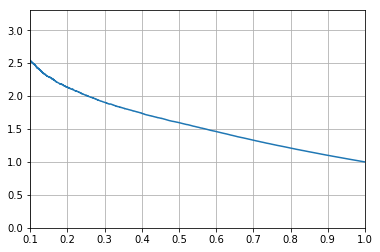

In [ ]:
plotlift(ytest, soft)

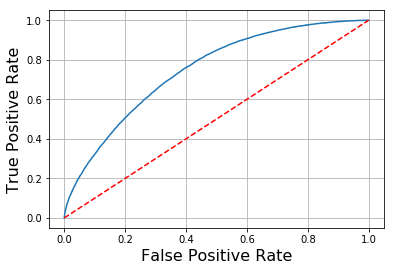

In [ ]:
pfa, power, _ = roc_curve(y_true=ytest, y_score=soft)
plt.plot(pfa, power)
plt.grid()
plt.plot([0, 1], [0, 1], 'r--')
plt.xlabel('False Positive Rate', fontsize=16);
plt.ylabel('True Positive Rate', fontsize=16);

# BONUS

# Field-aware Factorization Machines
<br>
<font color="red">
Afficher les noms des colonnes de la matrice Xtrain_ha
</font>

In [ ]:
Xtrain_ha.columns

Index(['hour', 'C1', 'banner_pos', 'site_category', 'app_id', 'app_domain',
       'app_category', 'device_type', 'device_conn_type', 'C14', 'C15', 'C16',
       'C17', 'C18', 'C19', 'C20', 'C21', 'weekday', 'user', 'site'],
      dtype='object')

<font color="red">
Créer une liste de liste de colonnes. La nème sous-liste comporte les noms des colonnes du nème champ.</font>

In [ ]:
fields = []
fields.append(['hour', 'weekday'])
fields.append(['C1','banner_pos'])
fields.append(['site','site_category'])
fields.append(['app_id', 'app_domain','app_category'])
fields.append(['user', 'device_type', 'device_conn_type'])
fields.append(['C14'])
fields.append(['C15', 'C16','C17', 'C18'])
fields.append(['C19', 'C20', 'C21'])


<font color="red">
Avec enumerate, générer un dictionnaire qui à chaque nom de colonne associe son champ.</font>

In [ ]:
dicFields = {name_col:i for i,f in enumerate(fields) for name_col in f}

Pour formatter les données au format LibFFM, nous devons nous assurer que deux colonnes différentes possèdent des modalités différentes. Pour cela, nous ajoutons devant chaque modalité une chaîne de caractère caractéristique de la colonne.
<center>
x --> 'nom de la colonne ' + str(x)
</center>
<br>
<font color="red">Effectuer cette transformation avec la méthode apply</font>

In [ ]:
Xtrain_ffm = pd.DataFrame()
Xtest_ffm = pd.DataFrame()
for col in Xtrain_ha.columns:
    Xtrain_ffm[col] = Xtrain_ha[col].apply(lambda x:col+str(x))
    Xtest_ffm[col] = Xtest_ha[col].apply(lambda x:col+str(x))

Avec np.unique, on créée la liste de toutes les modalités apparaissant dans toutes les colonnes.

In [ ]:
allvals = []
allcols_ffm = [col for f in fields for col in f]  # Toutes les colonnes appartenant à l'un des champ
for col in allcols_ffm:
    allvals.append(np.unique(Xtrain_ffm[col]))
allvals= [val for sublist in allvals for val in sublist]

<font color="red">
En utilisant "enumerate", créer un dictionnaire qui à chaque valeur associe son rang dans la liste allvals.</font>

In [ ]:
dicFeat = {val:i for i,val in enumerate(allvals)}

On les dataframe comme suit : 
dans chaque colonne "col", la valeur "x" est remplacée par la chaîne de caractère "f:v:1", où f est le champ associé à la colonne et v est l'indice de la modalité x.
<font color="red">
Inspecter le code ci-dessous.</font>

In [ ]:
for col in allcols_ffm:
    f = dicFields[col]
    Xtrain_ffm[col] = Xtrain_ffm[col].apply(lambda x:"{}:{}:1".format(f,dicFeat[x]) if x in dicFeat else "")
    Xtest_ffm[col] = Xtest_ffm[col].apply(lambda x:"{}:{}:1".format(f,dicFeat[x]) if x in dicFeat else "")

<font color="red">Pour les deux dataframe obtenues, concaténer à gauche la colonne de clics ytrain ou ytest correspondante</font>

In [ ]:
yXtrain_ffm = pd.concat([pd.DataFrame(ytrain).applymap(str),Xtrain_ffm],axis=1)
yXtest_ffm = pd.concat([pd.DataFrame(ytest).applymap(str),Xtest_ffm],axis=1)

<font color="red">Que produit la commande ci-dessous ?</font>

In [ ]:
train_w = yXtrain_ffm.apply(lambda row:' '.join(row.values),axis=1).values
test_w = yXtest_ffm.apply(lambda row:' '.join(row.values),axis=1).values

<font color="red">Ecrire les dataframe ci-dessus dans un fichier texte</font>

In [ ]:
thefile = open('test.txt','w')
for item in test_w:
    thefile.write("%s\n" % item)
thefile = open('train.txt','w')
for item in train_w:
    thefile.write("%s\n" % item)


Pour apprendre le modèle de FFM, on utilise la librairie LibFFM https://www.csie.ntu.edu.tw/~cjlin/libffm/  
Dans le répertoire notebooks/ se trouvent deux exécutables : ffm-train et ffm-predict.  
Dans jupyter notebook, le point d'exclamation ! permet de lancer une commande bash.  
L'usage est le suivant : 

-   `ffm-train'

    usage: ffm-train [options] training_set_file [model_file]

    options:  
    -l <lambda>: set regularization parameter (default 0.00002)  
    -k <factor>: set number of latent factors (default 4)  
    -t <iteration>: set number of iterations (default 15)  
    -r <eta>: set learning rate (default 0.2)  
    -s <nr_threads>: set number of threads (default 1)  
    -p <path>: set path to the validation set  
    --quiet: quiet model (no output)  
    --no-norm: disable instance-wise normalization  
    --auto-stop: stop at the iteration that achieves the best validation loss (must be used with -p)  
<br>
<font color="red">Apprendre le modèle. On pourra :  
- utiliser un paramètre de régularisation de 0.00001  
- utiliser un learning rate de 0.05  
- utiliser de l'ordre de 15 facteurs latents
- effectuer de l'ordre de 30 itérations  
- avec l'option -p, passer en paramètres de validation le ficher de test  
- activer le mode --autostop 
</font> 

In [ ]:
!./ffm-train -l 0.00001 -k 15 -t 30 -r 0.05 --auto-stop -p test.txt train.txt model

L'usage de ffm-predict est : ffm-predict nom-fichier-test nom-fichier-modèle fichier-dans-lequel-ecrire-la-prediction  
<font color="red">Effectuer la prédiction.</font>

In [ ]:
!./ffm-predict "test.txt" "model" "prediction_ffm"

<font color="red">Calculer la log_loss et l'aire sous la courbe roc.</font>

In [ ]:
soft = pd.read_csv("prediction_ffm",header=None)
log_loss(ytest,soft),roc_auc_score(ytest,soft)

# Blending

<font color="red">
Séparer les données de train Xtrain en deux avec train_test_split.</font>

In [ ]:
Xtrain_meth, Xtrain_blend, ytrain_meth, ytrain_blend = train_test_split(Xtrain,ytrain,test_size=0.2)

<font color="red">
Entrainer une régression logistique sur Xtrain_meth, et évaluer ses scores sur Xtrain_blend (conserver dans un vecteur).</font>

<font color="red">
Entrainer un xgboost sur Xtrain_meth, et évaluer ses scores sur Xtrain_blend (conserver dans un vecteur).</font>

<font color="red">
Entrainer un random forest sur Xtrain_meth, et évaluer ses scores sur Xtrain_blend (conserver dans un vecteur).</font>

<font color="red">
Entrainer un extraTrees sur Xtrain_meth, et évaluer ses scores sur Xtrain_blend (conserver dans un vecteur).</font>

<font color="red">
Entrainer un FFM sur Xtrain_meth, et évaluer ses scores sur Xtrain_blend (conserver dans un vecteur).</font>

<font color="red">
Concaténer tous les scores obtenus sur Xtrain_blend pour former une même matrice de design Zblend.</font>

<font color="red">
Entrainer une régression logistique sur (Zblend,ytrain_blend).</font>

<font color="red">
Evaluer les performances de la méthode sur la base de test.</font>